In [3]:
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
## Python SQL toolkit and Object Relational Mapper ##
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
## creates engine to hawaii.sqlite ##
hawaii_path = "../Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{hawaii_path}")
conn = engine.connect()

#hawaii_data_df = pd.read_sql("SELECT * FROM hawaii", conn)

In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

# Exploratory Precipitation Analysis

In [12]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

In [13]:
# Find the most recent date in the data set.
measDate = [Measurement, Measurement.date]
DateGroup = session.query(*measDate).group_by(Measurement.date).order_by(Measurement.date).all()
lastMeasureDate = DateGroup[-1][1]

lastMeasureDate


'2017-08-23'

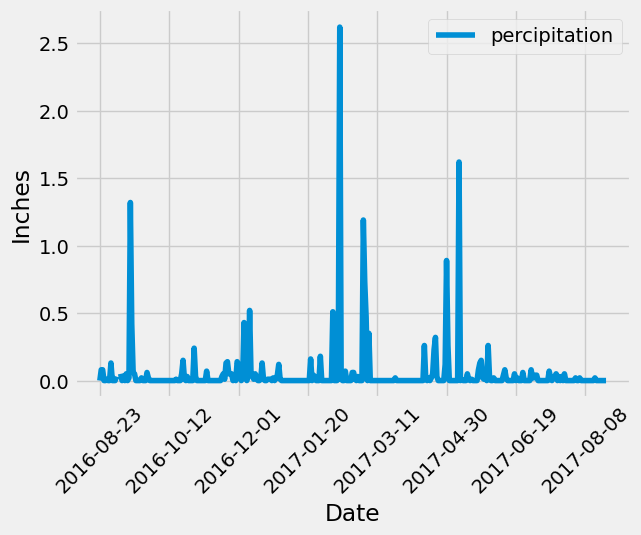

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database. 
lastMeasureDate

# Calculate the date one year from the last date in data set.
lastYear = lastMeasureDate[:4]

lastDate = str(int(lastYear) - 1) + lastMeasureDate[4:]

# Perform a query to retrieve the data and precipitation scores
rainDate = [Measurement.prcp, Measurement.date]

lastYearGroup = session.query(*rainDate).\
    filter(func.strftime(Measurement.date) >= lastDate).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_df = pd.DataFrame(lastYearGroup)

# Sort the dataframe by date
rain_df = rain_df.sort_values('date', ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
rain_df = rain_df.rename(columns = {'prcp': 'percipitation'} )

rain_df.plot('date', rot = 45, xlabel = 'Date', ylabel = 'Inches')
#plt.set_xticklabels(rain_df,rotation = 45)
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
rainStats = pd.DataFrame(
    {
        '': [
            'count',
            'mean',
            'var',
            'STdev',
            'min',
            '25%',
            '50% (median)',
            '75%',
            'max'
        ],
        'percipitation':[
            rain_df['percipitation'].count(),
            rain_df['percipitation'].mean(),
            rain_df['percipitation'].var(),
            rain_df['percipitation'].std(),
            rain_df['percipitation'].min(),
            rain_df['percipitation'].quantile(q = 0.25),
            rain_df['percipitation'].median(),
            rain_df['percipitation'].quantile(q = 0.75),
            rain_df['percipitation'].max()
        ]
    }
)

rainStats.set_index('')
rainStats


,,percipitation
0,count,364.000000
1,mean,0.048709
2,var,0.041996
3,STdev,0.204930
4,min,0.000000
5,25%,0.000000
6,50% (median),0.000000
7,75%,0.020000
8,max,2.620000


In [16]:
# Close Session
session.close()

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
stations = [Station, Station.station]
totalStations = session.query(*stations).\
    group_by(Station.station).\
    order_by(Station.station).all()

print( f"There are a total of {len(totalStations)} stations.")

There are a total of 9 stations.


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

stationCounting = [Measurement.station, Measurement.date]

## Create empty lists ##
stationList = []

stationName = []
stationCounts = []

## count the number of measurements per station ##
for i in range(0, len(totalStations)):

    ### count per station ###
    stationCount = session.query(*stationCounting).\
        group_by(Measurement.date).\
        filter(Measurement.station == totalStations[i][1]).\
        order_by( Measurement.station ).\
        all()

    ### append counts to list ###
    stationName.append( totalStations[i][1] )
    stationCounts.append( len(stationCount) )
    stationList.append((stationCounts[i], stationName[i]))
    stationCounts.sort(reverse = True)

stationRank = stationList
stationRank.sort(reverse = True)

stationRank

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stationTemp = [Measurement.station, Measurement.tobs, Measurement.date]

stationTempStats = session.query(*stationTemp).\
        group_by(Measurement.date).\
        filter(Measurement.station == stationRank[0][1]).\
        order_by( Measurement.date ).\
        all()

stationTemps = []
stationDates = []
for i in range(stationRank[0][0]):
    stationTemps.append(stationTempStats[i][1])
    stationDates.append(stationTempStats[i][2])


stationTemps_df = pd.DataFrame({
    'date': stationDates,
    'temp': stationTemps
    })


print(
    f"""
    Lowest temperature: {stationTemps_df['temp'].min()}° F
    Average temperature: {round(stationTemps_df['temp'].mean(), 1)}° F
    Highest temperature: {stationTemps_df['temp'].max()}° F
    """)




    Lowest temperature: 54.0° F
    Average temperature: 71.7° F
    Highest temperature: 85.0° F
    


<Axes: xlabel='temperature'>

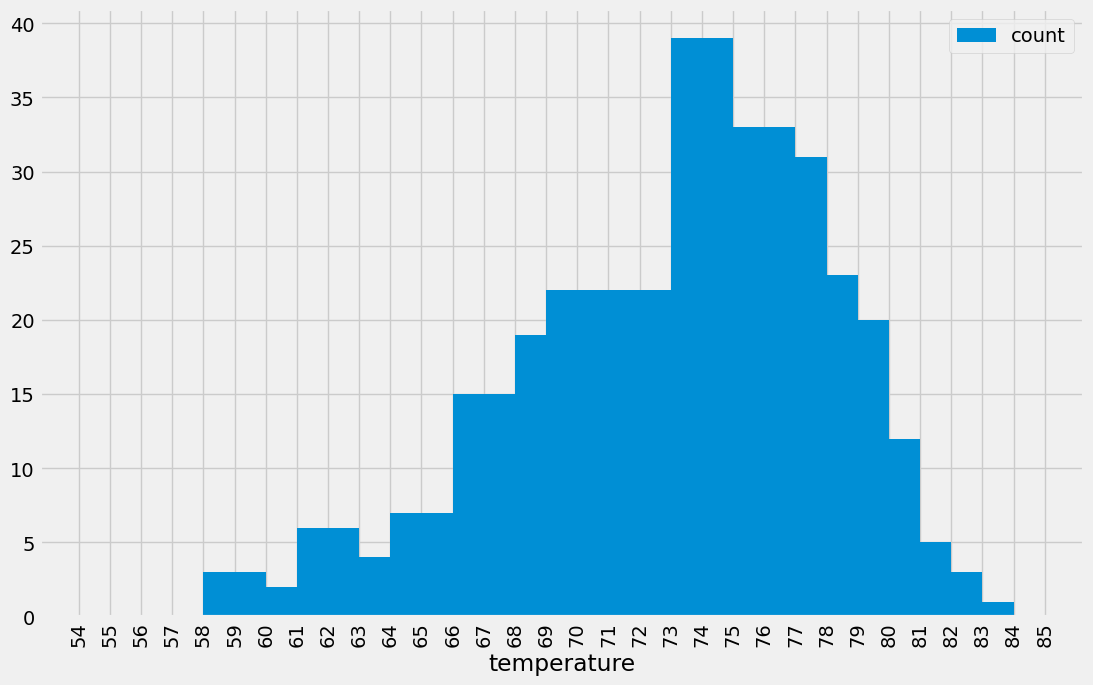

In [76]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

minTemp = int(stationTemps_df['temp'].min())
maxTemp = int(stationTemps_df['temp'].max())

## Get the last 12 Months of temps ##

stationTempys = [Measurement.station, Measurement.date, Measurement.tobs ]
stationMost = session.query(*stationTempys).\
        filter(Measurement.station == stationRank[0][1]).\
        all()
earliestDateStation = str(int(stationMost[-1][1][:4]) - 1) + stationMost[-1][1][4:]
stationTempStats = session.query(*stationTempys).\
        filter(Measurement.station == stationRank[0][1]).\
        filter( Measurement.date >= earliestDateStation).\
        all()


tempCounts = []
for i in range(minTemp, maxTemp + 1):
    
    tempCount = session.query(*stationTempys).\
        filter(Measurement.station == stationRank[0][1]).\
        filter( Measurement.date >= earliestDateStation).\
        filter( Measurement.tobs == i).\
        all()
    
    tempCounts.append(len(tempCount))

tempCounts


bin = []
for j in range(minTemp, maxTemp + 1):
    bin.append(j)

temp_df = pd.DataFrame(
    {
        'temperature': bin,
        'count': tempCounts
    },
    index = bin
)

temp_df.plot.bar(x = 'temperature', y = 'count', rot = 90, width = 2, figsize = (12, 7.5))


# Close Session

In [77]:
# Close Session
session.close()